In [30]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
names = open("./names.txt").read().splitlines()

In [3]:
SPECIAL_CHAR = "."
vocab = [SPECIAL_CHAR] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [4]:
block_size = 4
X, y = [], []

for name in names:
  name_chars = [SPECIAL_CHAR] * block_size + list(name) + [SPECIAL_CHAR]
  for i in range(len(name_chars) - block_size):
    X.append([vocab.index(char) for char in name_chars[i : i + block_size]])
    y.append(vocab.index(name_chars[i + block_size]))


split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = (
  Tensor(X[:split]),
  Tensor(y[:split]),
  Tensor(X[split:]),
  Tensor(y[split:]),
)

X_train, y_train, X_test, y_test

(<Tensor <LB CLANG (182516, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (182516,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>)

In [5]:
class EmbeddedMLP:
  def __init__(
    self,
    vocab_size,
    embed_size,
    input_size,
    output_size,
    h=[(200, Tensor.relu), (100, Tensor.relu)],
  ):
    self.input_size = input_size
    self.layers = [nn.Embedding(vocab_size, embed_size)]
    prev_layer_size = input_size * embed_size
    self.layers.append(lambda x: x.reshape((x.shape[0], -1)))
    for layer_size, layer_activation in h:
      self.layers.append(nn.Linear(prev_layer_size, layer_size))
      self.layers.append(layer_activation)
      prev_layer_size = layer_size
    self.layers.append(nn.Linear(prev_layer_size, output_size))

  def __call__(self, x: Tensor):
    assert len(x.shape) == 2 and x.shape[1] == self.input_size
    return reduce(lambda x, l: l(x), self.layers, x)


embedded_mlp = EmbeddedMLP(
  vocab_size, embed_size=10, input_size=block_size, output_size=vocab_size
)

In [6]:
optim = nn.optim.Adam(nn.state.get_parameters(embedded_mlp))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = embedded_mlp(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [7]:
for step in range(1, 20001):
  loss = train_step()
  if step == 1 or step % 1000 == 0:
    Tensor.training = False
    acc = (embedded_mlp(X_test).argmax(axis=1) == y_test).mean().item()
    print(f"step {step}, loss {loss.item():.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.30, acc 1.63%
step 1000, loss 2.23, acc 26.82%
step 2000, loss 2.08, acc 27.15%
step 3000, loss 2.05, acc 27.76%
step 4000, loss 2.17, acc 28.69%
step 5000, loss 2.17, acc 28.58%
step 6000, loss 1.91, acc 29.14%
step 7000, loss 1.98, acc 28.60%
step 8000, loss 1.91, acc 29.14%
step 9000, loss 2.06, acc 29.34%
step 10000, loss 1.89, acc 29.93%
step 11000, loss 2.07, acc 29.12%
step 12000, loss 1.99, acc 29.69%
step 13000, loss 1.97, acc 29.86%
step 14000, loss 1.93, acc 29.90%
step 15000, loss 1.97, acc 30.15%
step 16000, loss 2.05, acc 30.43%
step 17000, loss 2.01, acc 30.31%
step 18000, loss 2.22, acc 30.09%
step 19000, loss 1.77, acc 30.44%
step 20000, loss 2.00, acc 29.53%
step 21000, loss 2.03, acc 29.94%
step 22000, loss 1.86, acc 30.59%
step 23000, loss 1.78, acc 30.50%
step 24000, loss 2.00, acc 30.56%
step 25000, loss 1.88, acc 30.29%
step 26000, loss 1.78, acc 30.91%
step 27000, loss 1.78, acc 30.95%
step 28000, loss 1.90, acc 30.92%
step 29000, loss 2.04, acc 3

In [27]:
def generate_word(starting_chars="", max_len=float("inf")):
  word = SPECIAL_CHAR * block_size + starting_chars
  while len(word[1:]) < max_len:
    x = Tensor([[vocab.index(char) for char in word[-block_size:]]])
    y = embedded_mlp(x).squeeze()
    counts = y.exp()
    p = counts / counts.sum()
    curr_char = np.random.choice(a=vocab, p=p.numpy())
    if curr_char == SPECIAL_CHAR:
      break
    word += curr_char
  return word[block_size:]

In [29]:
generated_names = []
for _ in range(32000):
  generated_names.append(generate_word())

generated_names[:100]

['anna',
 'kaileysen',
 'trayderdie',
 'trace',
 'ellaset',
 'araoluwato',
 'emmee',
 'kaiya',
 'eoprinxiya',
 'clava',
 'sathaur',
 'vindsey',
 'elimphomn',
 'brechanor',
 'sailynn',
 'eleny',
 'raylen',
 'bryn',
 'fluwox',
 'tria',
 'odhi',
 'savia',
 'seon',
 'emonci',
 'chancar',
 'jaysen',
 'zhahliah',
 'iray',
 'naet',
 'arley',
 'lina',
 'jalaynes',
 'eyabriano',
 'kajan',
 'lariyah',
 'razim',
 'braesie',
 'amitha',
 'cheses',
 'emil',
 'corvy',
 'maileen',
 'wakitanna',
 'calliyah',
 'allar',
 'melia',
 'ryler',
 'keilah',
 'chasitan',
 'kelsandri',
 'rafielyssa',
 'macaidyn',
 'giilyn',
 'inayaquiliann',
 'za',
 'agdyn',
 'ismaniah',
 'szevory',
 'galgan',
 'emalynn',
 'cleu',
 'hanlee',
 'bax',
 'mamika',
 'erat',
 'dhael',
 'amairaniah',
 'harto',
 'auston',
 'kell',
 'revyn',
 'journnox',
 'bortay',
 'ashonnellen',
 'avayahnarolo',
 'kinxleigha',
 'astyna',
 'davi',
 'stefra',
 'aidan',
 'pradyn',
 'dashyatt',
 'amerys',
 'arhann',
 'croa',
 'jamirai',
 'daee',
 'kean',
 '

In [31]:
def create_transition_matrix(names):
  N = np.zeros((vocab_size, vocab_size), dtype=int)

  for name in names:
    name_chars = [SPECIAL_CHAR] + list(name) + [SPECIAL_CHAR]
    for char_a, char_b in zip(name_chars, name_chars[1:]):
      N[vocab.index(char_a), vocab.index(char_b)] += 1

  return N


def draw_transition_matrix(N: np.ndarray):
  plt.figure(figsize=(16, 16))
  plt.imshow(N, cmap="Blues")
  for i in range(vocab_size):
    for j in range(vocab_size):
      text = vocab[i] + vocab[j]
      plt.text(j, i, text, ha="center", va="bottom", color="gray")
      plt.text(j, i, N[i, j], ha="center", va="top", color="gray")

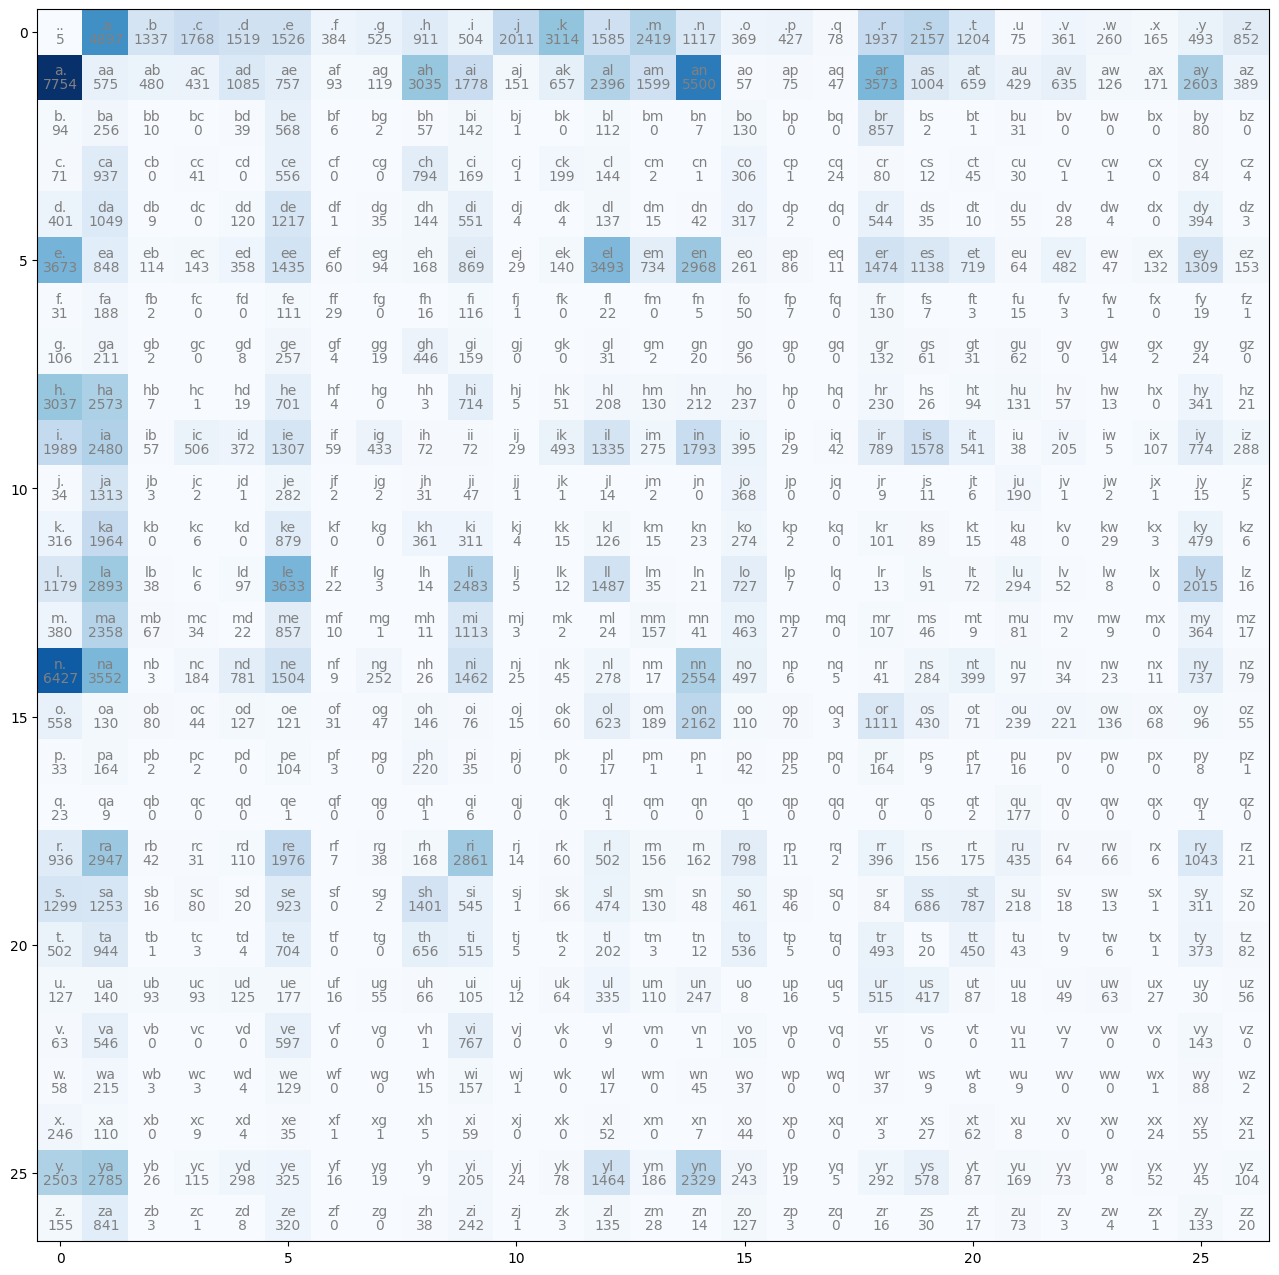

In [32]:
draw_transition_matrix(create_transition_matrix(generated_names))